In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

In [2]:
train = pd.read_csv("train.csv")[["GrLivArea", "YearBuilt"]]
target = pd.read_csv("train.csv")["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=0)

## Introduction Easy data confirmation

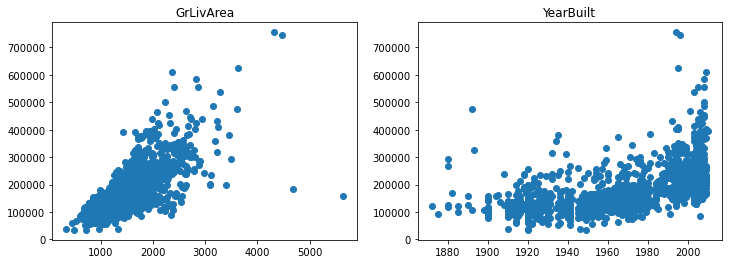

In [3]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(train["GrLivArea"], target)
axes[0].set_title("GrLivArea")
axes[1].scatter(train["YearBuilt"], target)
axes[1].set_title("YearBuilt")
plt.show()

# Problem 1 
## scratch mounting

In [5]:
np.random.seed(0)

## Data standardization
sc = StandardScaler()
sc.fit(np.concatenate([X_train, X_val]))
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

## Learning (Linear Regression & SVM & Decision Tree)
lr = LinearRegression().fit(X_train, y_train)
svr = SVR().fit(X_train, y_train)
tree = DecisionTreeRegressor().fit(X_train, y_train)

## Forecast
lr_pred  = lr.predict(X_val)
svr_pred = svr.predict(X_val)
tree_pred = tree.predict(X_val)

## Blending
blending_all_pred = np.array([lr_pred, svr_pred, tree_pred]).mean(axis=0) ## Mix all
blending_lr_and_tree_pred = np.array([lr_pred, tree_pred]).mean(axis=0)#Linear regression & decision tree
## Rating
lr_score = mean_squared_error(y_val, lr_pred)
svr_score = mean_squared_error(y_val, svr_pred)
tree_score = mean_squared_error(y_val, tree_pred)

blending_all_score = mean_squared_error(y_val, blending_all_pred)
blending_lr_and_tree_score = mean_squared_error(y_val, blending_lr_and_tree_pred)

results = pd.DataFrame(data=[lr_score, svr_score, tree_score, blending_all_score, blending_lr_and_tree_score],
                       index=["LinearRegression", "svr", "tree", "blending_all", "blending_lr_and_tree"],
                       columns=["mean_squared_error"])

display(results.sort_values(by="mean_squared_error"))


,mean_squared_error
blending_lr_and_tree,2.589777e+09
blending_all,2.842546e+09
LinearRegression,2.942067e+09
tree,3.320593e+09
svr,7.221523e+09


. The best score was when the linear regression & decision tree model predictions were blended.

. Try changing the blending ratio of linear regression & decision tree predictions

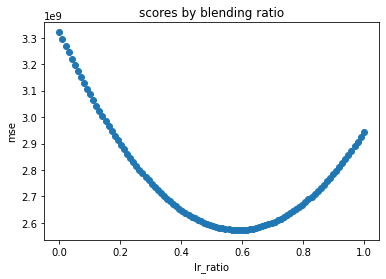

best mse score: 2.573e+09
lr ratio: 0.586
tree ratio: 0.414


In [6]:
lr_ratio = np.linspace(0,1,100)
scores = []
for p in lr_ratio:
    y_blending = p * lr_pred  + (1-p) * tree_pred
    score = mean_squared_error(y_val, y_blending)
    scores.append(score)

plt.scatter(lr_ratio, scores)
plt.ylabel("mse")
plt.xlabel("lr_ratio")
plt.title("scores by blending ratio")
plt.show()

min_value = min(scores)
min_index = scores.index(min_value)
min_ratio = lr_ratio[min_index]

print("best mse score: {:.3e}\nlr ratio: {:.3f}\ntree ratio: {:.3f}".format(min_value, min_ratio, 1-min_ratio))

### Blending by hyperparameters

In [ ]:
# Data standardization
sc = StandardScaler()
sc.fit(np.concatenate([X_train, X_val]))
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

## Learning
svr1 = SVR(kernel="linear", C=1, epsilon=0.1, coef0=0.0).fit(X_train, y_train)
svr2 = SVR(kernel="poly", C=10, epsilon=0.1, coef0=0.0).fit(X_train, y_train)
svr3 = SVR(kernel="rbf", C=1, epsilon=0.1, coef0=0.0).fit(X_train, y_train)

## Forecast
svr1_pred  = svr1.predict(X_val)
svr2_pred = svr2.predict(X_val)
svr3_pred = svr3.predict(X_val)
blending_pred = np.array([svr1_pred, svr2_pred, svr3_pred]).mean(axis=0)

## Rating
svr1_score = mean_squared_error(y_val, svr1_pred)
svr2_score = mean_squared_error(y_val, svr2_pred)
svr3_score = mean_squared_error(y_val, svr3_pred)
blending_score = mean_squared_error(y_val, blending_pred)

results = pd.DataFrame(data=[svr1_score, svr2_score, svr3_score, blending_score],
                       index=["svr1", "svr2", "svr3", "blending_pred"],
                       columns=["params changed mse"])

display(results.sort_values(by="params changed mse"))

### Blending by preprocessing method of input data

In [9]:
## Data reload
train = pd.read_csv("train.csv")[["GrLivArea", "YearBuilt"]]
target = pd.read_csv("train.csv")["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=0)

In [11]:
## Standardization
sc = StandardScaler()
sc.fit(np.concatenate([X_train, X_val]))
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)

##vLogarithmic transformation
X_train_log = X_train.apply(np.log1p)
X_val_log = X_val.apply(np.log1p)

## clipping
p01 = X_train.quantile(0.01)
p99 = X_val.quantile(0.99)
X_train_clip = X_train.clip(p01, p99, axis=1)
X_val_clip = X_val.clip(p01, p99, axis=1)

## Learning (Linear Regression)
lr_std = LinearRegression().fit(X_train_std, y_train)
lr_log = LinearRegression().fit(X_train_log, y_train)
## lr_clip = LinearRegression().fit(X_train_clip, y_train)

## Forecast
lr_std_pred  = lr_std.predict(X_val_std)
lr_log_pred  = lr_log.predict(X_val_log)
#lr_clip_pred = lr_clip.predict(X_val_clip)
blending_pred = np.array([lr_std_pred, lr_log_pred]).mean(axis=0)

## Rating
lr_std_score = mean_squared_error(y_val, lr_std_pred)
lr_log_score = mean_squared_error(y_val, lr_log_pred)
#lr_clip_score = mean_squared_error(y_val, lr_clip_pred)
blending_score = mean_squared_error(y_val, blending_pred)

results = pd.DataFrame(data=[lr_std_score, lr_log_score,  blending_score],
                       index=["LR standard data", "LR log-scaler data",  "blending_pred"],
                       columns=["data changed mse"])

display(results.sort_values(by="data changed mse"))

,data changed mse
blending_pred,2.843176e+09
LR log-scaler data,2.900008e+09
LR standard data,2.942067e+09


# Problem 2 
## Scratch mounting of bagging

In [13]:
## Measure the score when learning alone
X_train, X_val, y_train ,y_val = train_test_split(train, target, test_size=0.2, random_state=2)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_val)
score = mean_squared_error(y_val, y_pred)
print("LinearRegression-model single learning score is {:.3e}".format(score))

LinearRegression-model single learning score is 1.873e+09


In [15]:
## Learn with bagging
num_iter = 200
X_train, X_val, y_train ,y_val = train_test_split(train, target, test_size=0.2, random_state=2)

bagging_pred = np.zeros([num_iter, len(X_val)])

for i in range(num_iter):
    X_train_bag, _, y_train_bag ,_ = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
    lr = LinearRegression().fit(X_train_bag, y_train_bag)
    y_pred = lr.predict(X_val)
    bagging_pred[i, :] = y_pred

mean_bagging_pred = bagging_pred.mean(axis=0)
score = mean_squared_error(y_val, mean_bagging_pred)
print("baggin mse score is: {:.3e}".format(score))

baggin mse score is: 1.873e+09


# Problem 3
## Stacking scratch mounting

In [17]:
## Data read
train = pd.read_csv("train.csv")[["GrLivArea", "YearBuilt"]]
target = pd.read_csv("train.csv")["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=0)

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print("mse: {:.3e}".format(mean_squared_error(y_test, lr.predict(X_test))))

mse: 2.942e+09


In [21]:
## Define learning model
model_list = [LinearRegression, SVR, DecisionTreeRegressor]

## Cross-validation
K = 4
kf = KFold(n_splits=K, shuffle=True, random_state=0)

## Dictionary type definition to save an instance
instance_dict = {i:[] for i in range(len(model_list))}
scores = np.zeros([len(model_list), K])

## Define the shape of blending data
blend_data = np.zeros([len(model_list), len(y_train)])

#Stacking
for i, model in enumerate(model_list):
    for j, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]
        
        ins = model().fit(tr_x, tr_y)
        y_pred = ins.predict(va_x)
        
        blend_data[i, va_idx] = y_pred
        instance_dict[i].append(ins)
        scores[i, j] = mean_squared_error(va_y, y_pred)

## Learning using blended data (select the model with the best score)
best_model_idx = np.argmin(scores.mean(axis=1))
last_model = model_list[best_model_idx]()
last_model.fit(blend_data.T, y_train)

LinearRegression()

In [22]:
blend_data = np.zeros([len(model_list), len(X_test)])

for i, models in enumerate(instance_dict.values()):
    mean_pred = np.zeros([K, len(X_test)])
    for j, week_model in enumerate(models):
        pred = week_model.predict(X_test)
        mean_pred[j, :] = pred
    blend_data[i,:] = mean_pred.mean(axis=0)

last_predict = last_model.predict(blend_data.T)
print("stacking mse: {:.3e}".format(mean_squared_error(y_test, last_predict)))

stacking mse: 2.604e+09
